# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch
from fastai.text.models.awd_lstm import *
from fastai.text.models.transformer import *

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [7]:
from src.music_transformer import *

In [8]:
path = Path('../../data/midi/v16/piano_duet/')

## Single Stream Encoding

In [9]:
config = v15m_config(vocab); config

{'ctx_len': 150,
 'n_layers': 16,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.2,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'rand_transpose': True,
 'rand_bptt': False,
 'note_range': (9, 137),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 632}

## Fastai Learner

In [10]:
# data = load_music_data(path, cache_name='tmp/sample', vocab=vocab, **config)
data = load_music_data(path/'tmp/sample', cache_name='', vocab=vocab, **config)

In [11]:
saved_models = get_files(path/'models', recurse=True, extensions=['.pth']); saved_models

[PosixPath('../../data/midi/v16/piano_duet/models/txl/hq/1_ep50.pth'),
 PosixPath('../../data/midi/v16/piano_duet/models/txl/hq/1_ep50_best.pth'),
 PosixPath('../../data/midi/v16/piano_duet/models/txl/hook_c/1_ep16_nt_best.pth'),
 PosixPath('../../data/midi/v16/piano_duet/models/txl/hook_c/1_ep16.pth'),
 PosixPath('../../data/midi/v16/piano_duet/models/txl/hook_c/1_ep16_nt.pth'),
 PosixPath('../../data/midi/v16/piano_duet/models/txl/hook_c/1_ep16_best.pth'),
 PosixPath('../../data/midi/v16/piano_duet/models/txl/lq/1_ep50.pth'),
 PosixPath('../../data/midi/v16/piano_duet/models/txl/lq/1_ep50_best.pth')]

In [12]:
load_path = saved_models[-4]; load_path

PosixPath('../../data/midi/v16/piano_duet/models/txl/hook_c/1_ep16_nt.pth')

In [13]:
learn = load_music_learner(data, config.copy(), load_path)

In [14]:
# learn = music_model_learner(data, config.copy())

## Debugging prediction values

In [15]:
# xb,yb = data.one_batch(cpu=False)

# learn.pred_batch(batch=(xb,yb))

## Prediction

In [16]:
data_dir = 'data/midi/v16/'
source_dir = 'piano_duet'
file_path = Path('../../')

csv_path = path/f'{source_dir}.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,6,9,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [17]:
# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('the-days')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory']; results.head()

,source,ht_mode,ht_key,md5,ht_time_signature,artist,mxl,genres,numpy,parts,title,song_url,ht_bpm,midi,section,midi_title,ht_offset
18214,hooktheory,6.0,F#,7dd970e5b2298572d55d5ff9a6b2e294,4.0,mary-hopkin,NaN,NaN,piano_duet/hooktheory/pianoroll/m/mary-hopkin/...,chorus,those-were-the-days,https://www.hooktheory.com/theorytab/view/mary...,84.0,midi_sources/hooktheory/pianoroll/m/mary-hopki...,chorus,Those Were The Days,3.0
19165,hooktheory,1.0,C,ca48d8cd856eb4465663713e953d3fb1,4.0,avicii,NaN,"Country,Electronic",piano_duet/hooktheory/pianoroll/a/avicii/the-d...,"verse,chorus,outro",the-days,https://www.hooktheory.com/theorytab/view/avic...,128.0,midi_sources/hooktheory/pianoroll/a/avicii/the...,verse,The Days,0.0
19166,hooktheory,1.0,C,97871c33e2320d060ea7e7b23b41e93b,4.0,avicii,NaN,"Country,Electronic",piano_duet/hooktheory/pianoroll/a/avicii/the-d...,"verse,chorus,outro",the-days,https://www.hooktheory.com/theorytab/view/avic...,128.0,midi_sources/hooktheory/pianoroll/a/avicii/the...,chorus,The Days,0.0
19167,hooktheory,1.0,C,a39280c8eb256fca6ca20768720279e8,4.0,avicii,NaN,"Country,Electronic",piano_duet/hooktheory/pianoroll/a/avicii/the-d...,"verse,chorus,outro",the-days,https://www.hooktheory.com/theorytab/view/avic...,127.0,midi_sources/hooktheory/pianoroll/a/avicii/the...,outro,The Days,0.0


In [18]:
idx = 1
file = file_path/data_dir/results.numpy.values[idx]; 
# orig = file_path/data_dir/results.mxl.values[idx];
orig = file_path/data_dir/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v16/piano_duet/hooktheory/pianoroll/a/avicii/the-days/verse_key_original.npy'),
 PosixPath('../../data/midi/v16/midi_sources/hooktheory/pianoroll/a/avicii/the-days/verse_key_original.mid'))

In [19]:
seed_len = 140
song_np = np.load(file)
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(to_single_stream(seed_np, vocab=vocab))[None]
if torch.cuda.is_available(): xb = xb.cuda()

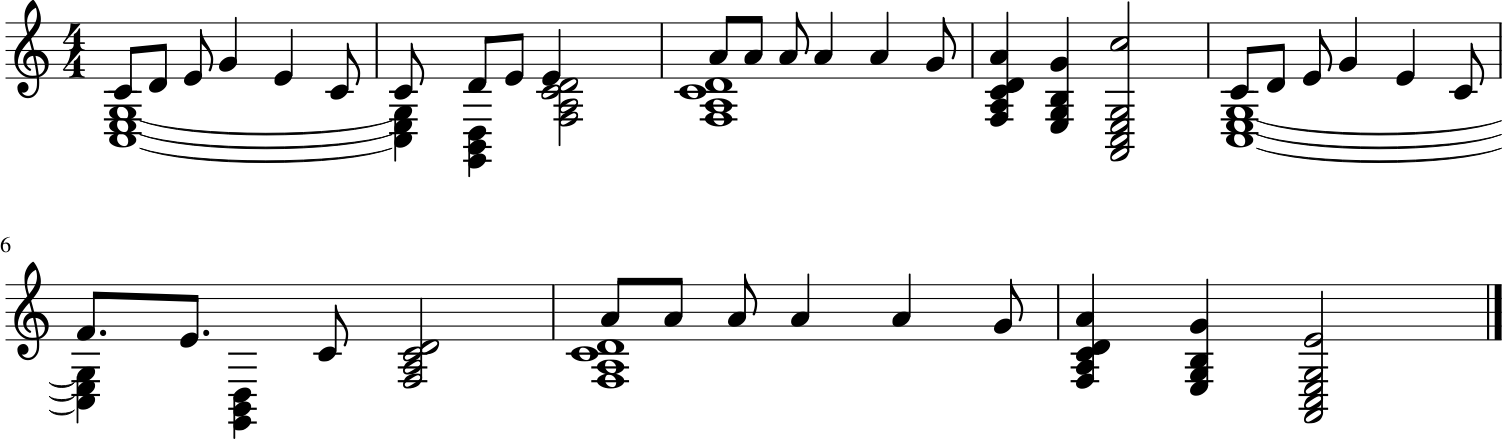

In [20]:
seed_stream = npenc2stream(seed_np)
seed_stream.show()

In [21]:
vocab.textify(xb[0])

'xxbos xxpad n60 d6 n55 d60 n52 d60 n48 d60 xxsep d6 n62 d6 xxsep d6 n64 d6 xxsep d6 n67 d12 xxsep d12 n64 d12 xxsep d12 n60 d6 xxsep d6 n60 d6 xxsep d12 n62 d6 n50 d12 n47 d12 n43 d12 xxsep d6 n64 d6 xxsep d6 n64 d12 n62 d24 n60 d24 n57 d24 n53 d24 xxsep d24 n69 d6 n62 d48 n60 d48 n57 d48 n53 d48 xxsep d6 n69 d6 xxsep d6 n69 d6 xxsep d6 n69 d12 xxsep d12 n69 d12 xxsep d12 n67 d6 xxsep d6 n69 d12 n62 d12 n60 d12 n57 d12 n53 d12 xxsep d12 n67 d12 n59 d12 n55 d12 n52 d12 xxsep d12 n72 d24 n55 d24 n52 d24 n48 d24 n45 d24 xxsep d24 n60 d6 n55 d60 n52 d60 n48 d60 xxsep d6 n62 d6 xxsep d6 n64 d6 xxsep d6 n67 d12 xxsep d12 n64 d12 xxsep d12 n60 d6 xxsep d6 n65 d9 xxsep d9 n64 d9 xxsep d3 n50 d12 n47 d12 n43 d12 xxsep d6 n60 d6 xxsep d6 n62 d24 n60 d12 n60 d24 n57 d24 n53 d24 xxsep d24 n69 d6 n62 d48 n60 d48 n57 d48 n53 d48 xxsep d6 n69 d6 xxsep d6 n69 d6 xxsep d6 n69 d12 xxsep d12 n69 d12 xxsep d12 n67 d6 xxsep d6 n69 d12 n62 d12 n60 d12 n57 d12 n53 d12 xxsep d12 n67 d12 n59 d12 n55 d12 n52 d

In [22]:
seed_stream.show('midi')

In [23]:
out_s, seed_s = learn.predict_topk(xb, n_words=400, temperatures=(1.2,0.7), min_bars=12, top_k=40, top_p=0.5)

In [24]:
seed_s

array([  0,   1,  69, 143,  64, 197,  61, 197,  57, 197, ...,  64, 161,  61, 161,  57, 161,  54, 161,   8, 162])

In [25]:
vocab.textify(out_s)

'n93 d6 n52 d12 n48 d12 n45 d12 xxsep d5 n93 d6 xxsep d7 n91 d6 n52 d12 n48 d12 n45 d12 xxsep d5 n88 d6 xxsep d7 n88 d12 n91 d12 n52 d12 n48 d12 n45 d12 xxsep d12 n86 d12 n52 d12 n48 d12 n45 d12 xxsep d12 n81 d6 n52 d12 n48 d12 n45 d12 xxsep d5 n81 d6 xxsep d7 n79 d6 n52 d12 n48 d12 n45 d12 xxsep d5 n76 d6 xxsep d7 n76 d12 n67 d12 n52 d12 n48 d12 n45 d12 xxsep d12 n74 d12 n71 d12 n52 d12 n48 d12 n45 d12 xxsep d12 n64 d6 n52 d12 n48 d12 n45 d12 xxsep d5 n67 d6 xxsep d7 n64 d12 n52 d12 n48 d12 n45 d12 xxsep d12 n64 d12 n52 d12 n48 d12 n45 d12 xxsep d12 n67 d12 n52 d12 n48 d12 n45 d12 xxsep d12 n61 d6 n52 d12 n48 d12 n45 d12 xxsep d5 n61 d6 xxsep d7 n61 d6 n52 d12 n48 d12 n45 d12 xxsep d5 n61 d6 xxsep d7 n61 d6 n52 d12 n48 d12 n45 d12 xxsep d5 n62 d6 xxsep d7 n60 d12 n52 d12 n48 d12 n45 d12 xxsep d12 n93 d6 n52 d12 n48 d12 n45 d12 xxsep d5 n93 d6 xxsep d7 n91 d6 n52 d12 n48 d12 n45 d12 xxsep d5 n88 d6 xxsep d7 n88 d12 n52 d12 n48 d12 n45 d12 xxsep d12 n86 d12 n52 d12 n48 d12 n45 d12 xxsep

In [26]:
out_s

array([102, 143,  61, 149,  57, 149,  54, 149,   8, 142, ...,   8, 149,  87, 143,  76, 185,  73, 185,  69, 185])

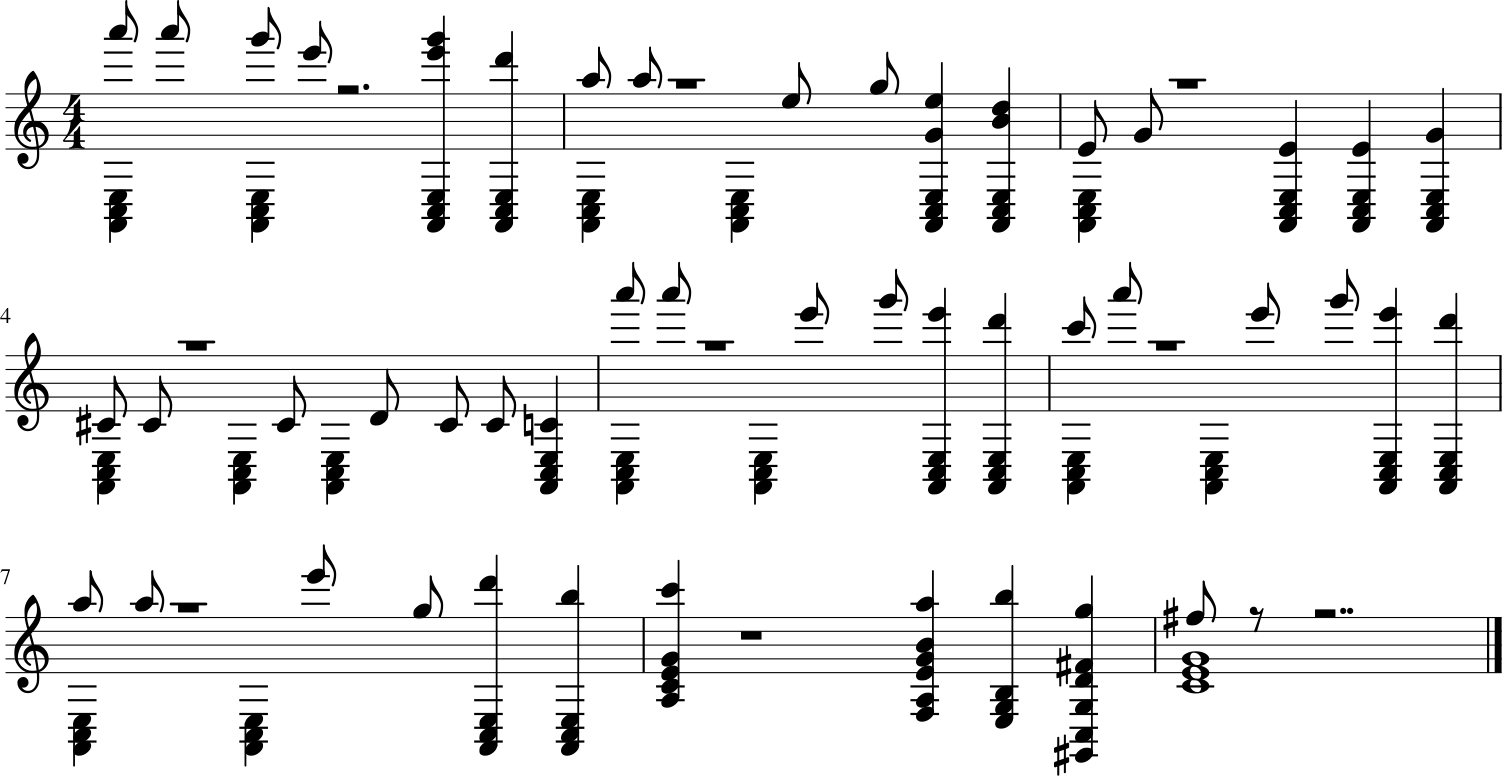

In [27]:
stream = npenc2stream(to_double_stream(out_s))
stream.show()

In [28]:
stream.show('midi')

## Prediction

In [33]:
x,y = data.one_batch(cpu=False)

In [34]:
out,seed = learn.predict(x, n_words=100)

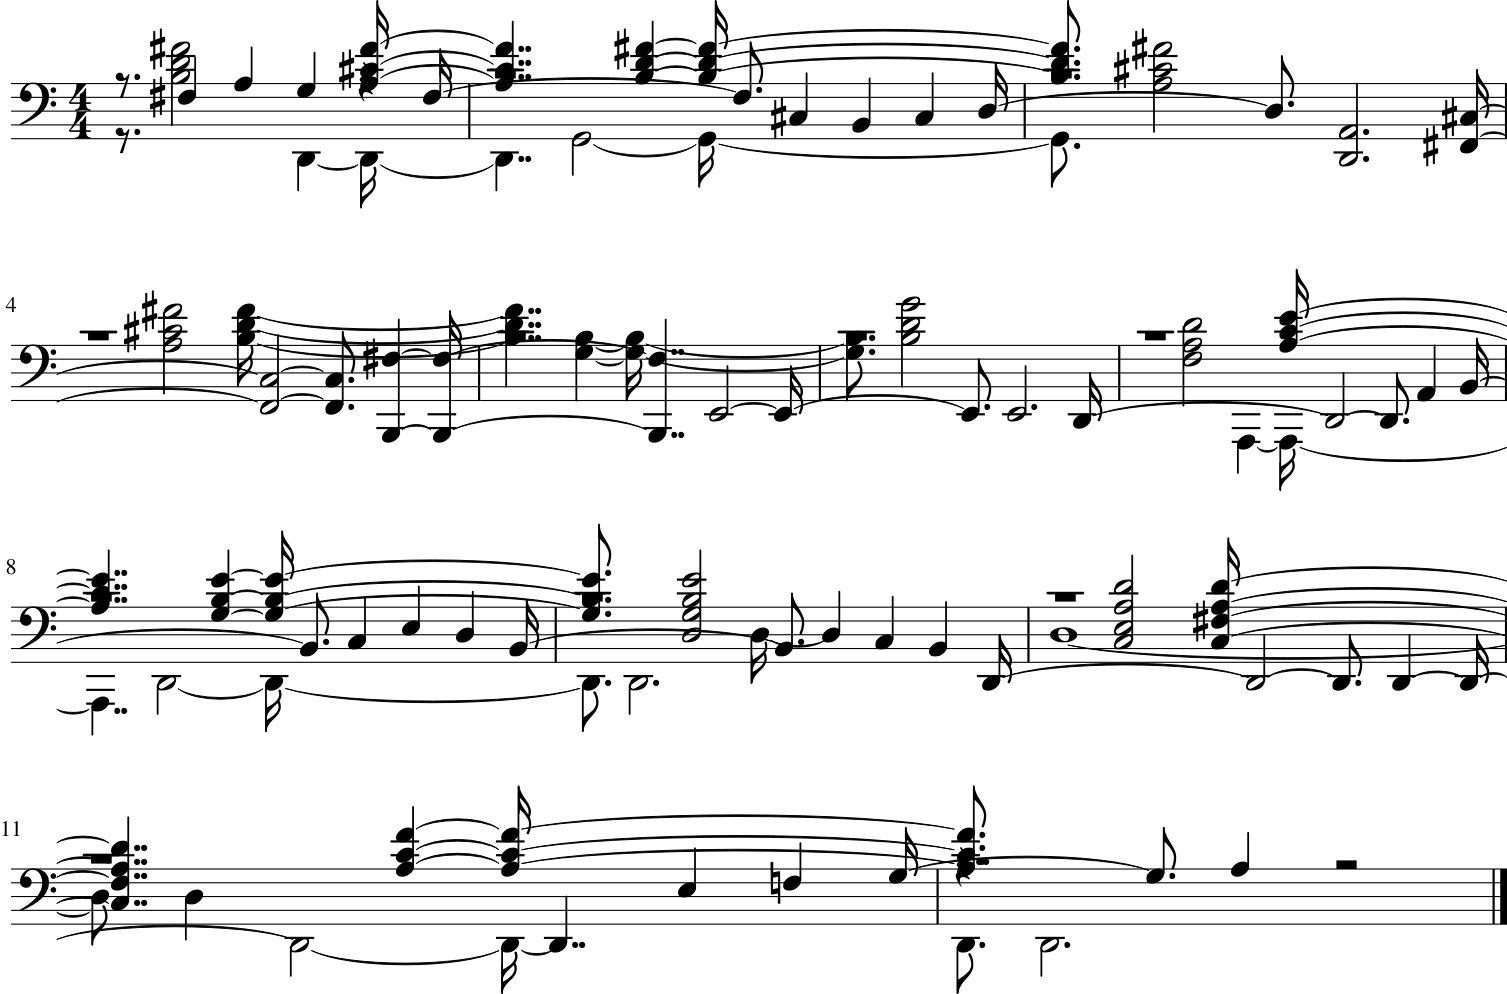

In [35]:
stream = npenc2stream(double(seed))
stream.show()

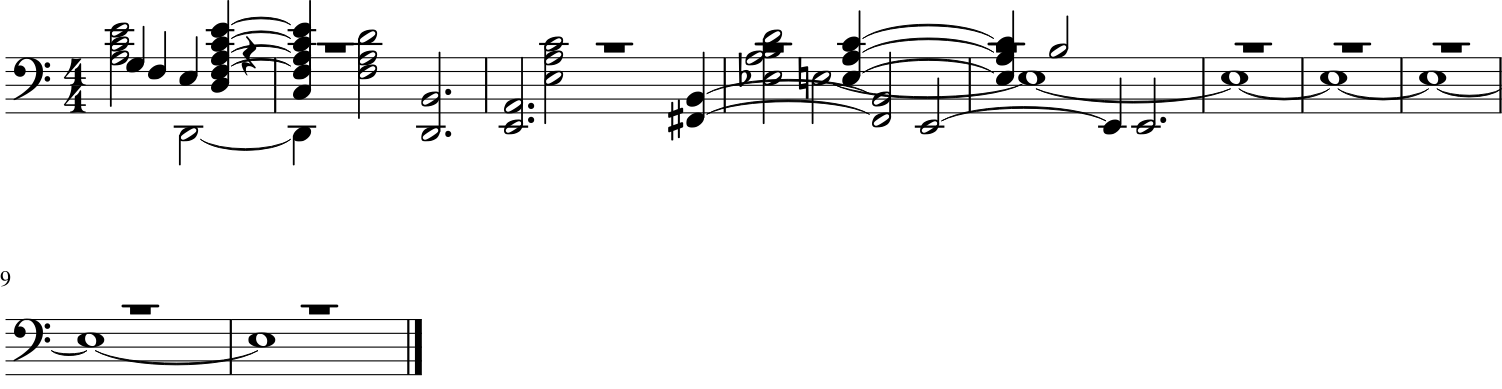

In [36]:
stream = npenc2stream(double(out))
stream.show()

In [ ]:
stream.show('midi')

### From song

In [37]:
seed_len = 60
files = get_files(path/'hooktheory', extensions=['.npy'], recurse=True)

In [38]:
# Loading from specific file
keywords = ['third', 'eye']
def contains_keywords(f): return all([k in str(f) for k in keywords])
search = [f for f in files if contains_keywords(f)]; search

[PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/verse-and-pre-chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/verse-and-pre-chorus_key_original.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/chorus_key_original.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/z/zun/satori-maiden---third-eye/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/t/third-eye-blind/jumper/chorus_key_original.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/t/third-eye-blind/jumper/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/t/third-eye-blind/never-let-you-go/verse-and-pre-chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/t/third-eye-blind/never-let-you-go/verse-and-pre-cho

In [39]:
# file = np.random.choice(files)
file = search[-2]
file

PosixPath('../../data/midi/v15/piano_duet/hooktheory/pianoroll/t/third-eye-blind/semi-charmed-life/chorus_key_original.npy')

In [40]:
#good_one = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/c/cool-and-new-web-comic/tick---tock/chorus.npy')
# la_bamba = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/r/ritchie-valen/la-bamba/chorus.npy')
# third_eye = PosixPath('data/midi/v7/midi_encode/np/hook_1bar_nopos/hooktheory/t/third-eye-blind/semi-charmed-life/chorus.npy')

In [41]:
seed_np = np.load(file)[:seed_len]
xb = torch.tensor(seed_np).cuda()[None]

### Predict

In [43]:
out, seed = learn.predict(xb, n_words=340, temperature=.7, min_p=0.01)

ValueError: too many values to unpack (expected 2)

### Actual prediction

In [59]:
seq = npenc2seq(np.array(out))
chordarr = seq2chordarr(seq)
stream = chordarr2stream(chordarr)

Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing
Note with 0 duration. continuing


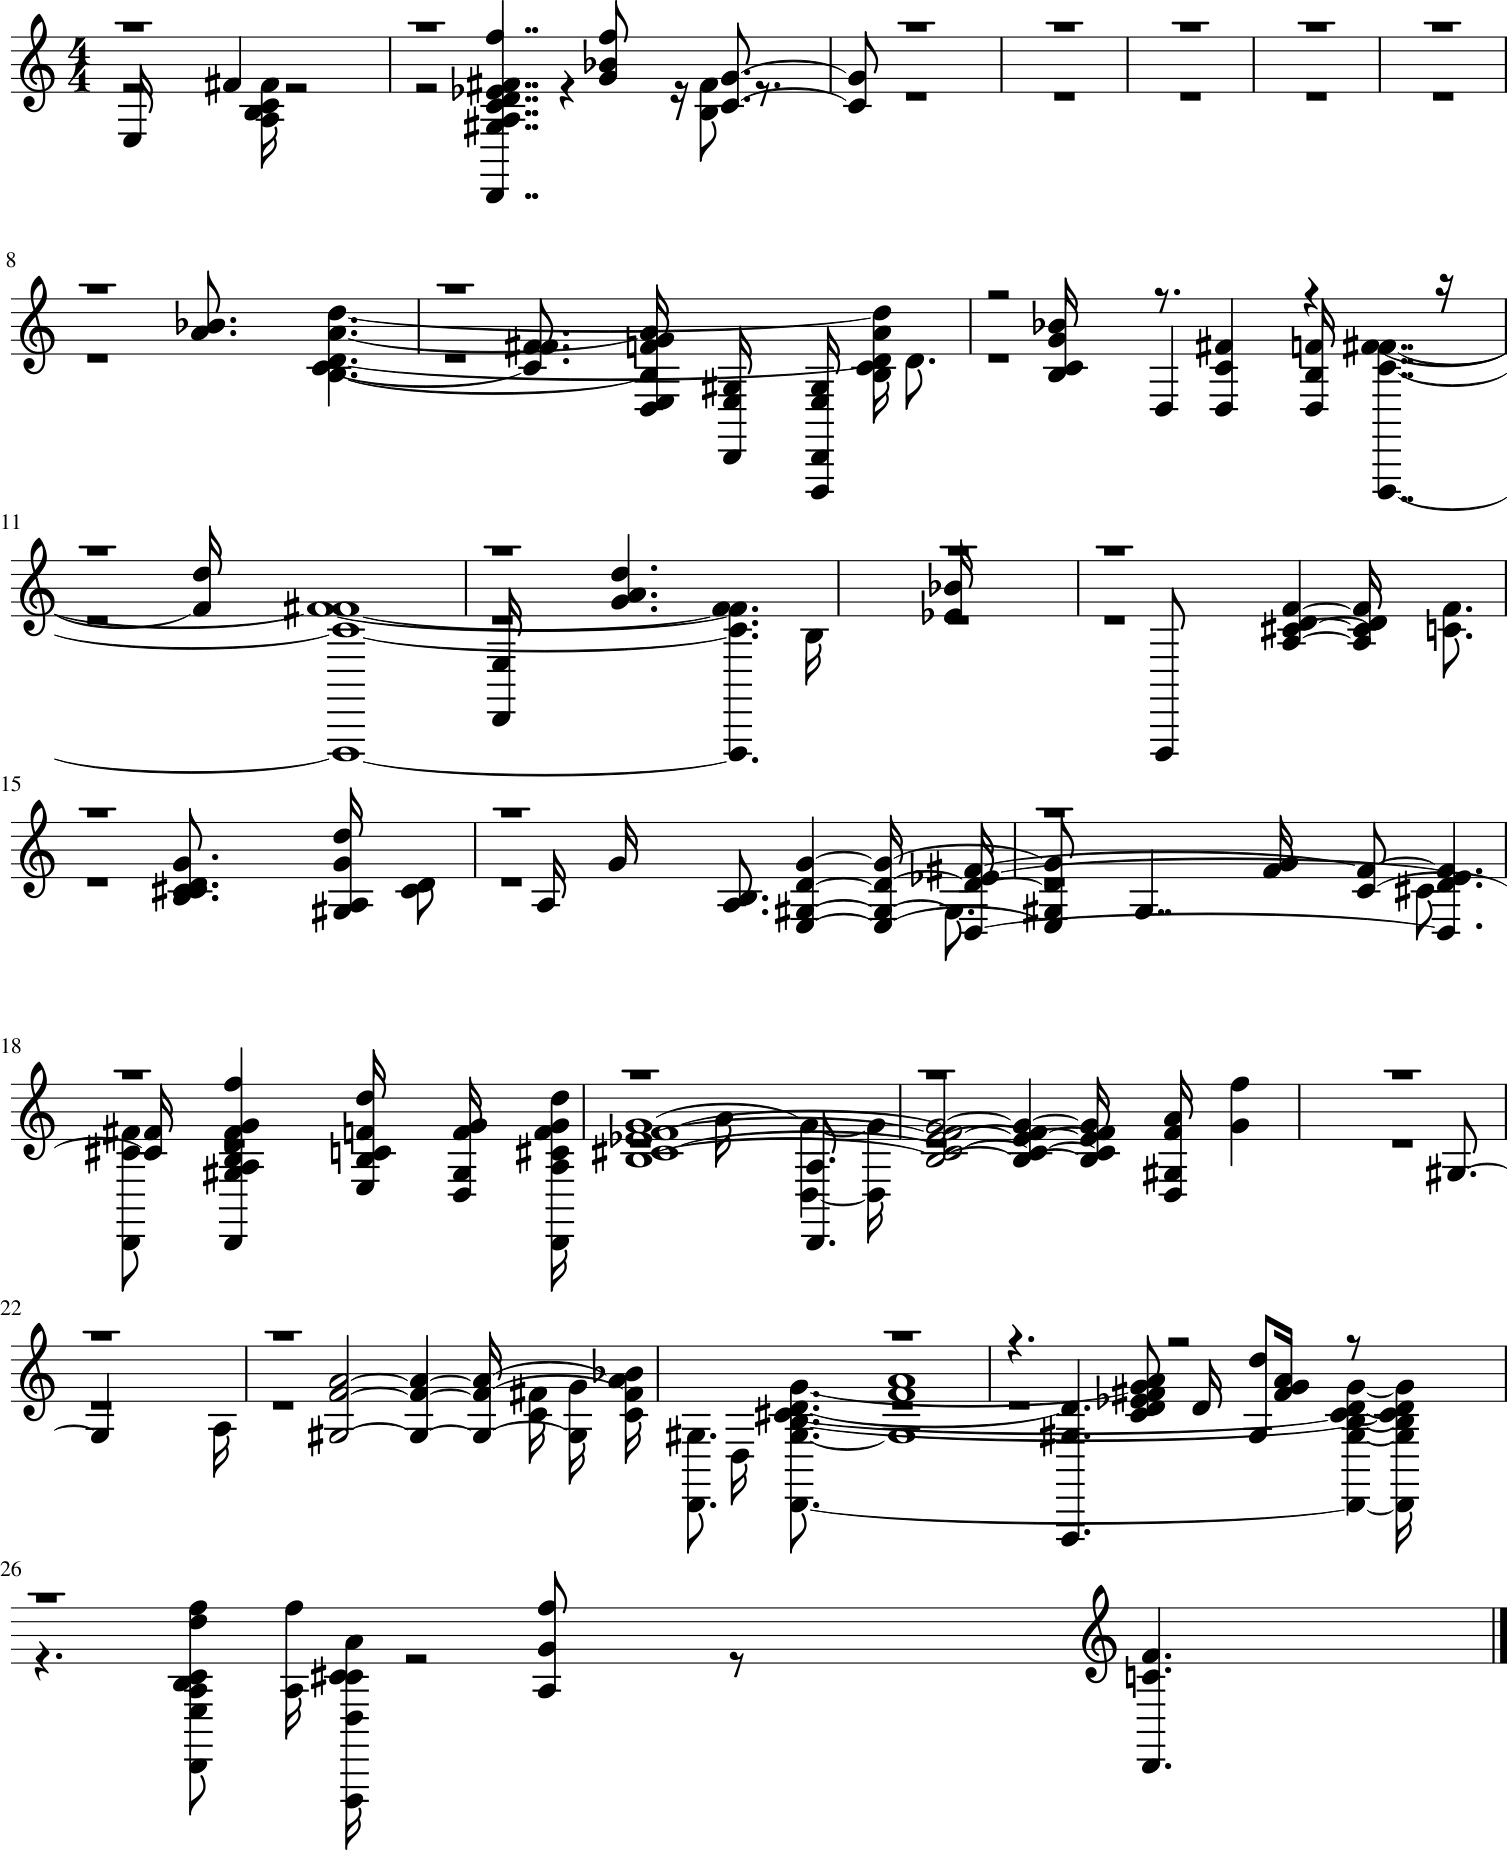

In [60]:
stream.show()

In [61]:
stream.show('midi')

## Seed

In [434]:
seed_song = dec_arr(seed)
seed_stream = seed_song.to_stream()

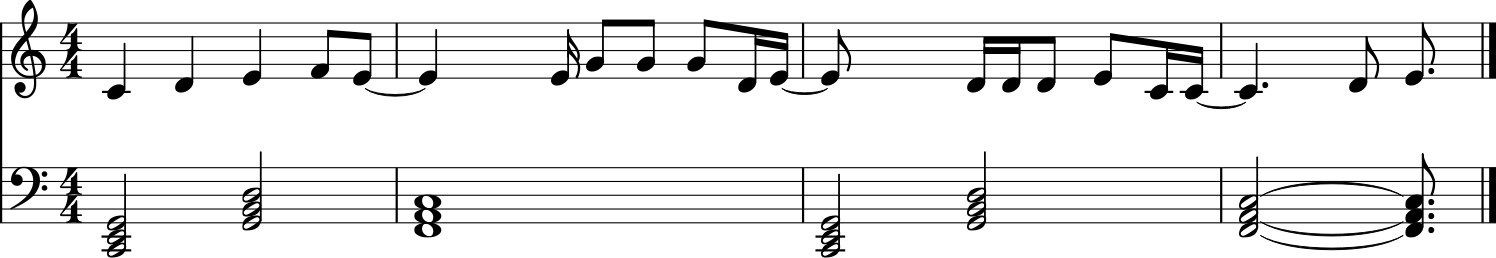

In [435]:
seed_stream.show()

In [436]:
seed_stream.show('midi')